<a href="https://colab.research.google.com/github/lattmi/Latta/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

# Keras Tuning
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.4MB/s 


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# neural network with keras
import io
import math
import IPython
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

tf.keras.backend.set_floatx('float64')

2.3.0


# **Data Preparation**

In [ ]:
raw_data = pd.read_csv('housing_price_small.csv')
raw_data.head(n=15)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1461 non-null   object
 1   1       1461 non-null   object
 2   2       1461 non-null   object
 3   3       1202 non-null   object
 4   4       1461 non-null   object
 5   5       1461 non-null   object
 6   6       92 non-null     object
 7   7       1461 non-null   object
 8   8       1461 non-null   object
 9   9       1461 non-null   object
 10  10      1461 non-null   object
 11  11      1461 non-null   object
 12  12      1461 non-null   object
 13  13      1461 non-null   object
 14  14      1461 non-null   object
 15  15      1461 non-null   object
 16  16      1461 non-null   object
 17  17      1461 non-null   object
 18  18      1461 non-null   object
 19  19      1461 non-null   object
 20  20      1461 non-null   object
 21  21      1461 non-null   object
 22  22      1461 non-null   

In [ ]:
# drop useless information
df = raw_data.drop(columns='Id')

# transform categorical variables to dummy
df = pd.get_dummies(df)

# replace NA with 0
df = df.fillna(0)

# check shape 
df.shape


(1460, 289)

# **Split Dataset into Training and Test Sets**

In [ ]:
# shuffle input data
df = df.sample(frac=1).reset_index(drop=True)

# train and test sets
train_dataset = df.sample(frac=0.8, random_state=1)
test_dataset = df.drop(train_dataset.index)


(1168, 289)

Check split sizes

In [ ]:
train_dataset.shape

(1168, 289)

In [ ]:
test_dataset.shape

(292, 289)

# **Data Exploration**

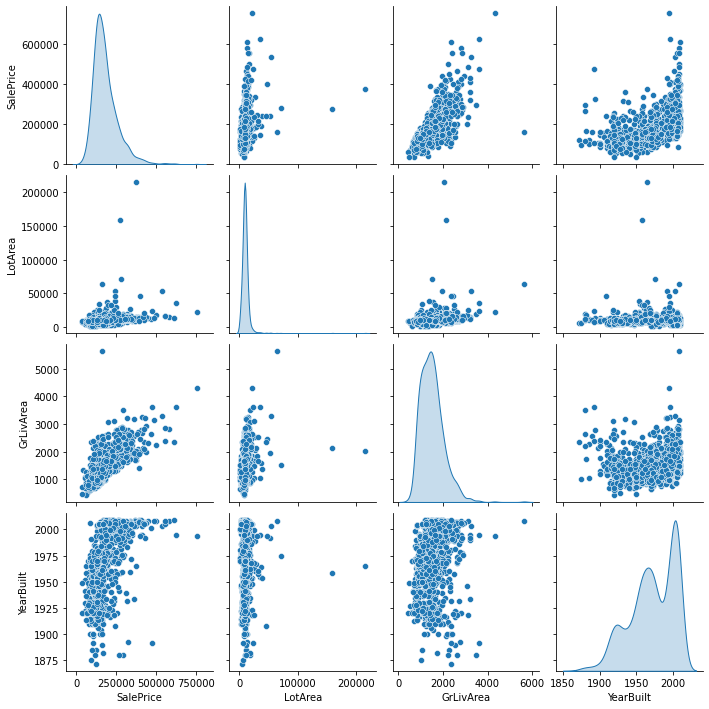

In [ ]:
# pairplot of numeric variables
sns.pairplot(train_dataset[['SalePrice', 'LotArea', 'GrLivArea', 'YearBuilt']], diag_kind = 'kde')

Variables appear to be linearly correlated with SalePrice which means model will do ok.

Taking a look at overall statistics with SalePrice removed (popping).

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('SalePrice')
train_stats = train_stats.transpose()
display(train_stats)

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1168.0,56.053082,41.447717,20.0,20.00,50.0,70.0,190.0
LotFrontage,1168.0,57.948630,34.879606,0.0,43.00,63.0,79.0,313.0
LotArea,1168.0,10339.148116,9181.170806,1300.0,7587.25,9544.5,11608.5,215245.0
OverallQual,1168.0,6.123288,1.371845,1.0,5.00,6.0,7.0,10.0
OverallCond,1168.0,5.574486,1.106776,1.0,5.00,5.0,6.0,9.0
...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,1168.0,0.003425,0.058445,0.0,0.00,0.0,0.0,1.0
SaleCondition_Alloca,1168.0,0.006849,0.082512,0.0,0.00,0.0,0.0,1.0
SaleCondition_Family,1168.0,0.012842,0.112643,0.0,0.00,0.0,0.0,1.0
SaleCondition_Normal,1168.0,0.821918,0.382746,0.0,1.00,1.0,1.0,1.0


**Split Features from Labels**

In [ ]:
# split explanatory variables (features) with output (label)
train_labels = train_dataset.pop('SalePrice')
test_labels = test_dataset.pop('SalePrice')

train_labels.head(n=10)

258     106000
267     403000
288     129900
649     200141
1233    230000
167     284000
926     176000
831     113000
1237    240000
426     152000
Name: SalePrice, dtype: int64

## **Normalize the data**

In [ ]:
def norm(x):
  return (x - train_stats['mean'])/ train_stats['std']

normed_train_data = norm(train_dataset).fillna(0)
normed_test_data = norm(test_dataset).fillna(0)

normed_train_data.head(n=15)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
258,2.507905,-1.059319,-0.922556,-0.089870,0.384462,-0.047484,-0.725738,0.137979,-0.254586,-0.280985,-0.954652,-1.304392,-1.745615,0.364190,-0.107356,-1.009019,-0.820396,-0.237124,-1.055114,1.230001,-1.097134,-0.203811,-0.941445,-0.947428,0.255364,-1.038531,-0.901436,-0.750339,-0.705111,-0.350714,-0.1157,-0.274812,-0.065158,-0.08232,0.984552,0.125463,-0.088083,-0.217929,-0.106046,-1.910565,...,1.188282,-0.041398,-0.185780,-0.097464,-0.041398,0.331921,-0.02926,-0.159496,-0.071827,-0.06554,0.310855,-0.259969,-0.150823,0.305864,-0.02926,-0.041398,-0.041398,-0.202393,-0.183302,-0.347589,-0.08301,-0.02926,-0.02926,-0.178255,-0.02926,-0.170441,-0.050724,-0.041398,-0.071827,-0.06554,-0.06554,-0.304188,-0.041398,0.390999,-0.271047,-0.058596,-0.08301,-0.114011,0.465275,-0.307534
267,0.095226,3.327198,0.522684,1.368020,-0.519063,0.777344,0.527558,2.255991,0.553067,-0.280985,0.448218,0.915416,0.848109,2.212687,-0.107356,2.465068,1.123260,-0.237124,0.773333,1.230001,1.445431,-0.203811,1.543544,0.611158,0.273365,1.663038,1.585705,-0.750339,1.504556,2.991208,-0.1157,-0.274812,-0.065158,-0.08232,0.248580,0.876954,-0.088083,-0.217929,-0.106046,0.522957,...,-0.840831,-0.041398,-0.185780,-0.097464,-0.041398,0.331921,-0.02926,-0.159496,-0.071827,-0.06554,0.310855,-0.259969,-0.150823,0.305864,-0.02926,-0.041398,-0.041398,-0.202393,-0.183302,-0.347589,-0.08301,-0.02926,-0.02926,-0.178255,-0.02926,-0.170441,-0.050724,-0.041398,-0.071827,-0.06554,-0.06554,-0.304188,-0.041398,0.390999,-0.271047,-0.058596,-0.08301,-0.114011,0.465275,-0.307534
288,-0.146041,-0.199218,-0.459544,0.639075,-0.519063,-1.334216,-1.689811,-0.571751,-0.959088,-0.280985,0.859206,-0.240970,-0.357316,0.937224,-0.107356,0.504045,-0.820396,-0.237124,0.773333,-0.762566,-1.097134,4.374092,0.922297,2.169743,0.129363,0.312253,-0.019205,-0.011734,-0.705111,3.040840,-0.1157,-0.274812,-0.065158,-0.08232,-0.855379,0.125463,-0.088083,-0.217929,-0.106046,-1.910565,...,1.188282,-0.041398,5.378098,-0.097464,-0.041398,-3.010183,-0.02926,-0.159496,-0.071827,-0.06554,0.310855,-0.259969,-0.150823,0.305864,-0.02926,-0.041398,-0.041398,-0.202393,-0.183302,-0.347589,-0.08301,-0.02926,-0.02926,-0.178255,-0.02926,-0.170441,-0.050724,-0.041398,-0.071827,-0.06554,-0.06554,-0.304188,-0.041398,0.390999,3.686239,-0.058596,-0.08301,-0.114011,-2.147425,-0.307534
649,-0.869845,1.291625,0.091040,0.639075,-0.519063,1.173262,1.057798,-0.571751,-0.959088,-0.280985,1.694959,0.584372,0.399938,-0.800363,-0.107356,-0.376493,-0.820396,-0.237124,0.773333,-0.762566,0.174148,-0.203811,-0.320198,0.611158,0.300365,0.312253,-0.150601,-0.750339,-0.402417,-0.350714,-0.1157,-0.274812,-0.065158,-0.08232,1.352539,-0.626028,-0.088083,-0.217929,-0.106046,0.522957,...,-0.840831,-0.041398,-0.185780,-0.097464,-0.041398,0.331921,-0.02926,-0.159496,-0.071827,-0.06554,0.310855,-0.259969,-0.150823,0.305864,-0.02926,-0.041398,-0.041398,-0.202393,-0.183302,-0.347589,-0.08301,-0.02926,-0.02926,-0.178255,-0.02926,-0.17044

# **Define the Model**

We will define a 2 layer NN with 64 nodes and rectified linear activation functions;


*   Input = # of features
*   Output = a single value

This uses the RMSprop for the optimizer and loss is based on MSE.



In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.01)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
  return model

model = build_model()

# **Inspect the Model**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                18496     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 22,721
Trainable params: 22,721
Non-trainable params: 0
_________________________________________________________________


Check output that they are not all zeros and are the right shape

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.89338923],
       [ 0.32277629],
       [ 0.01450344],
       [ 0.91601378],
       [ 0.7741896 ],
       [-0.45353444],
       [ 0.61872652],
       [ 0.30736559],
       [-0.22178987],
       [ 1.29793901]])

# **Train the Model**

In [ ]:
EPOCHS = 1000

start_time = datetime.now()

history = model.fit(
    normed_train_data, train_labels,
    epochs= EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[tfdocs.modeling.EpochDots()])

print("\nTraining took:", datetime.now() - start_time)


Epoch: 0, loss:37813057518.4582,  mae:179006.8995,  mse:37813057239.3616,  val_loss:36558060552.7521,  val_mae:173339.4359,  val_mse:36558059546.4297,  
....................................................................................................
Epoch: 100, loss:267800567.7687,  mae:6257.6266,  mse:267800565.7739,  val_loss:2439462186.1197,  val_mae:26368.7400,  val_mse:2439462227.2566,  
....................................................................................................
Epoch: 200, loss:31769099.2719,  mae:2970.7551,  mse:31769100.6135,  val_loss:1599155928.0684,  val_mae:24690.7960,  val_mse:1599155903.1589,  
....................................................................................................
Epoch: 300, loss:10033481.1809,  mae:2229.0257,  mse:10033481.2997,  val_loss:1414155675.3504,  val_mae:24391.1609,  val_mse:1414155651.7902,  
....................................................................................................
Epoch: 4

Look for a downward trend in loss, mae, mse, and the val_* metrics.

# **Visualize the Training Metrics**

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [SalePrice]')

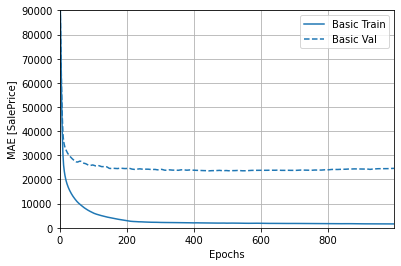

In [ ]:
plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 90000])
plt.ylabel('MAE [SalePrice]')

Text(0, 0.5, 'MSE [SalePrice^2]')

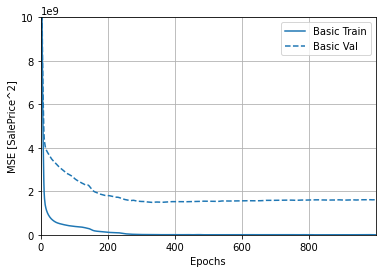

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 9999999999])
plt.ylabel('MSE [SalePrice^2]')

Rapid improvement, validation set diverges with training, which is normal.

If we want to improve performance, we would either need better and bigger data or tweak hyperparameters.

# **Automated Hyperparameter Searching**

Be careful with the # of parameters you have it try since its combinatorial -> will take super long. 

Things to try and change

*   step size
*   learning rate
*   optimizers
*   number of layers

...






In [ ]:
# set searching framework
def model_builder(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first and second layers
  # Choose an optimal value between 32-128 in intervals of 32
  hp_units1 = hp.Int('units1', min_value = 32, max_value = 128, step = 32)
  hp_units2 = hp.Int('units2', min_value = 32, max_value = 128, step = 32)
  model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
  model.add(keras.layers.Dense(units = hp_units2, activation = 'relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Nadam(learning_rate = hp_learning_rate),
                loss = 'mse', 
                metrics = ['mae', 'mse'])
  
  return model

tuner = kt.Hyperband(model_builder,
                     overwrite = True,
                     objective = 'val_mse', 
                     max_epochs = 1000,
                     factor = 3,
                     directory = '/content/drive/My Drive',
                     project_name = 'intro_to_kt')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)


In [ ]:
start_time = datetime.now()

tuner.search(normed_train_data, train_labels, epochs=1000, validation_data = (normed_test_data, test_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, {best_hps.get('units2')} in the second, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
print("\nSearching took:", datetime.now() - start_time)

Trial 46 Complete [00h 00m 01s]
val_mse: nan

Best val_mse So Far: nan
Total elapsed time: 00h 01m 12s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64, 96 in the second, and the optimal learning rate for the optimizer
is 0.01.


Searching took: 0:01:12.600705


Use these new values to train a new model;

The optimal number of units in the first densely-connected
layer is 64, 96 in the second, and the optimal learning rate for the optimizer
is 0.01.

In [ ]:
tf.keras.backend.set_floatx('float64')
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

EPOCHS = 1000

start_time = datetime.now()

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

print("\nTraining took:", datetime.now() - start_time)


Epoch: 0, loss:38371865492.5567,  mae:180331.7681,  mse:38371865723.9214,  val_loss:37515809590.7009,  val_mae:175926.5586,  val_mse:37515809718.7533,  
....................................................................................................
Epoch: 100, loss:384386012.3854,  mae:8289.7752,  mse:384386020.3368,  val_loss:2567057453.4017,  val_mae:26655.9125,  val_mse:2567057472.0082,  
....................................................................................................
Epoch: 200, loss:117054936.0875,  mae:4011.9443,  mse:117054934.9280,  val_loss:1827216195.8291,  val_mae:25631.2018,  val_mse:1827216241.1864,  
....................................................................................................
Epoch: 300, loss:12516742.0407,  mae:2176.7028,  mse:12516742.0202,  val_loss:1527169207.7949,  val_mae:25494.1455,  val_mse:1527169152.5230,  
....................................................................................................
Epoch:

MSE went from 5M+ to 1.6M which is pretty good (3x lower)

# **Make Predictions**

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()
display(test_predictions)

array([274551.54866379, 143615.78787573, 237597.16187584, 102341.08124269,
       175709.04299826, 232980.1447183 , 178116.63704845, 141827.49535867,
       204398.31386103, 163506.51362746, 133598.46738924, 263632.99204957,
                   nan, 153657.69667552,  73923.29916999, 115392.12670623,
       207014.85077899, 222061.98967487, 172106.33132648, 159616.31169522,
        99627.61027754, 139069.06455848, 141453.67570108, 150657.51326126,
                   nan, 108660.03441823, 250971.43575875, 111013.6136378 ,
       156038.80835657, 174602.62247562, 226623.61514343, 129945.32440006,
       122407.0443769 , 131397.32828267, 260512.84198311, 125037.93648927,
       175377.10276085, 302394.07590143, 107702.09503628, 167240.4013446 ,
       375945.43799548, 189787.75089987, 161360.22421921, 116152.9552136 ,
       164807.56251889, 174160.30494507, 114628.18185031, 128800.50312034,
       127320.47512838, 191354.73749118, 128745.39120539, 449245.19170365,
       432322.28331276, 2

Compare with actual sales price for test data

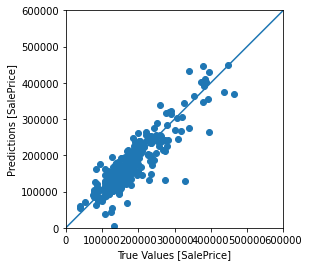

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
lims = [0, 600000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_predictions = [x if not math.isinf(x) else 0 for x in test_predictions]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


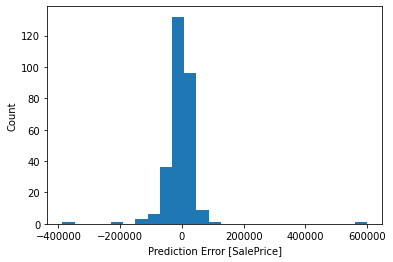

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [SalePrice]")
_ = plt.ylabel("Count")

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/housepricemodel')

# to load
# new_model = tf.keras.models.load_model('saved_model/housepricemodel')

INFO:tensorflow:Assets written to: saved_model/housepricemodel/assets
